<a href="https://colab.research.google.com/github/erewl/dsp/blob/models-XAI/xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install lime

     |████████████████████████████████| 275 kB 5.4 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=89beb2d7f79dcd59e2b964508f4d2def85ab673deffb1f14514c7a917da382c0
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
!pip install vit-keras

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 12.3 MB/s 


In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 2.6 MB/s 
     |████████████████████████████████| 97 kB 5.1 MB/s 
     |████████████████████████████████| 140 kB 34.0 MB/s 
     |████████████████████████████████| 180 kB 34.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=7b652421135edbf4a72c29ce98625b16dc1db2ec6f735753798fcea71a83c9a0
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=430728fcbacff17926b61d61e976f591d427c863ac133487cbb8ffae1119091e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [13]:
# import libraries
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras.backend as K
import tensorflow as tf

from lime import lime_image


In [ ]:
import wandb
from wandb.keras import WandbCallback

!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
# connect to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [6]:
# define data file paths
ROOT_train = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/train'
ROOT_val = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/val'
ROOT_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test'
knee_data_dir_train = pathlib.Path(ROOT_train)
knee_data_dir_val = pathlib.Path(ROOT_val)
knee_data_dir_test = pathlib.Path(ROOT_test)

In [7]:
ROOT_atest = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test'
knee_data_dir_atest = pathlib.Path(ROOT_atest)

In [11]:
if not data_augmentation:
    atest_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_atest,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
else: 
    atest_ds = test_datagen.flow_from_directory(
      knee_data_dir_atest,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 1526 images belonging to 5 classes.


In [10]:
# define some hyperparameters
batch_size = 32
img_height = 224
img_width = 224

# if set to True, image data will be augmented during training (rescaling, shear, zoom, flip)
data_augmentation = True

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# load train data 

if not data_augmentation:
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_train,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

else:
    train_ds = train_datagen.flow_from_directory(
      knee_data_dir_train,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 5778 images belonging to 5 classes.


In [15]:
# load val data

if not data_augmentation:
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_val,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

else:
    val_ds = train_datagen.flow_from_directory(
      knee_data_dir_val,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 826 images belonging to 5 classes.


In [16]:
# load test data

if not data_augmentation:
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      knee_data_dir_test,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
else: 
    test_ds = test_datagen.flow_from_directory(
      knee_data_dir_test,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='sparse'
      # , color_mode='grayscale'
      )

Found 1656 images belonging to 5 classes.


In [17]:
def show_k_images(k):
  plt.figure(figsize=(10, 10))
  for images, labels in test_ds.take(1):
    for i in range(k):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]])
      plt.axis("off")

In [ ]:
# try binary classification [0, 1] vs [2, 3, 4]

In [ ]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

In [ ]:
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [ ]:
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

In [ ]:
uniquetr, countstr = np.unique(train_labels, return_counts=True)
dict(zip(uniquetr, countstr))

{0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}

In [ ]:
uniquete, countste = np.unique(test_labels, return_counts=True)
dict(zip(uniquete, countste))

{0: 639, 1: 296, 2: 447, 3: 223, 4: 51}

In [ ]:
uniqueva, countsva = np.unique(val_labels, return_counts=True)
dict(zip(uniqueva, countsva))

{0: 328, 1: 153, 2: 212, 3: 106, 4: 27}

### Keras Model Training

In [ ]:
# load DenseNet169

model = tf.keras.applications.DenseNet169(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=5,
)

In [ ]:
# load DenseNet201

model = tf.keras.applications.DenseNet201(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling='max',
    classes=5,
)

In [ ]:
# ResNet, UNet, ViT

In [ ]:
try:
  from vit_keras import vit, utils
except:
  !pip install vit_keras

In [ ]:
image_size = 224
model = vit.vit_l32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=5
)

1226670080/1226658854 [==============================] - 43s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [ ]:
# https://stackoverflow.com/questions/59305514/tensorflow-how-to-use-tf-keras-metrics-in-multiclass-classification
class CategoricalTruePositives(tf.keras.metrics.Metric):

    def __init__(self, num_classes, batch_size,
                 name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes    

        self.cat_true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.flatten(y_true)

        true_poss = K.sum(K.cast((K.equal(y_true, y_pred)), dtype=tf.float32))

        self.cat_true_positives.assign_add(true_poss)

    def result(self):

        return self.cat_true_positives

In [ ]:
run = wandb.init(project="dsp", entity="tdebono",
           config={
               "learning_rate":0.0001,
               "epochs":200
           })

config = wandb.config

wandb: Currently logged in as: aml_mordeczki (use `wandb login --relogin` to force relogin)


In [ ]:
# compile the model
optimizer = tf.keras.optimizers.Adam(config.learning_rate)

model.compile(
  optimizer=optimizer,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
  )

In [ ]:
# define callbacks

def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# fit the model

h = model.fit(train_ds, 
              validation_data = val_ds,
              # validation_steps = 826 // batch_size, 
              epochs = config.epochs, verbose = 1, 
              callbacks=[early_stop, WandbCallback()]
              )

Epoch 1/200
181/181 [==============================] - 1812s 9s/step - loss: 1.4488 - accuracy: 0.3840 - val_loss: 1.4586 - val_accuracy: 0.3148
Epoch 2/200
181/181 [==============================] - 214s 1s/step - loss: 1.4136 - accuracy: 0.3962 - val_loss: 2.1019 - val_accuracy: 0.2409
Epoch 3/200
181/181 [==============================] - 214s 1s/step - loss: 1.3502 - accuracy: 0.4238 - val_loss: 1.8549 - val_accuracy: 0.3499
Epoch 4/200
181/181 [==============================] - 214s 1s/step - loss: 1.2498 - accuracy: 0.4637 - val_loss: 1.5665 - val_accuracy: 0.3741
Epoch 5/200
181/181 [==============================] - 216s 1s/step - loss: 1.1719 - accuracy: 0.4974 - val_loss: 1.5962 - val_accuracy: 0.3559
Epoch 6/200
181/181 [==============================] - 216s 1s/step - loss: 1.1058 - accuracy: 0.5260 - val_loss: 1.7034 - val_accuracy: 0.2918
Epoch 7/200
181/181 [==============================] - 216s 1s/step - loss: 1.0464 - accuracy: 0.5564 - val_loss: 2.4920 - val_accuracy

In [ ]:
def plot_performance(h):
  plt.plot(h.history['accuracy'])
  plt.plot(h.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

def plot_loss(h):
  plt.plot(h.history['loss'])
  plt.plot(h.history['val_loss'])
  plt.title('training loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

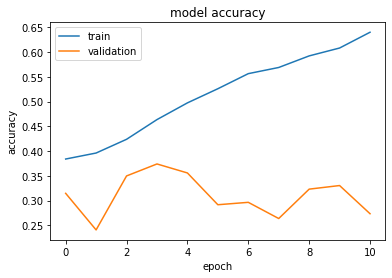

In [ ]:
plot_performance(h)

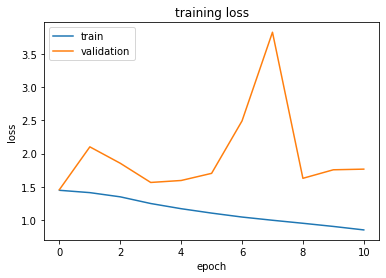

In [ ]:
plot_loss(h)

In [ ]:
score = model.evaluate_generator(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


Test loss:  1.7239184379577637
Test accuracy:  0.28683575987815857


In [ ]:
wandb.log({'Model': 'DenseNet201',
           'Augmentation': str(data_augmentation),
           'Test loss': score[0],
           'Test accuracy': score[1]})

In [ ]:
# run.join()
wandb.finish()

Test accuracy,▁
Test loss,▁
accuracy,▁▁▂▃▄▅▆▆▇▇█
epoch,▁▂▂▃▄▅▅▆▇▇█
loss,██▇▆▅▄▃▃▂▂▁
val_accuracy,▅▁▇█▇▄▄▂▅▆▃
val_loss,▁▃▂▁▁▂▄█▂▂▂
Augmentation,False
Model,DenseNet201
Test accuracy,0.28684
Test loss,1.72392


#### Evaluation Sandbox

In [ ]:
y_prob = model.predict(test_ds)
y_pred = y_prob.argmax(axis=-1)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test_labels, y_pred)

0.27053140096618356

In [ ]:
class_names = test_ds.class_names

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_gt, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.39      0.28      0.33       639
           1       0.06      0.00      0.01       296
           2       0.27      0.55      0.36       447
           3       0.14      0.14      0.14       223
           4       0.04      0.04      0.04        51

    accuracy                           0.28      1656
   macro avg       0.18      0.20      0.18      1656
weighted avg       0.25      0.28      0.25      1656



In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_gt, y_prob, average="weighted", multi_class="ovr")

0.5059442403177989

In [ ]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_gt, y_pred)

0.0026645405444089

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(y_gt, y_pred)


0.002906880427811962

In [ ]:
model.save('/content/drive/MyDrive/DSP-H3-Quin/model_4.h5')

### Load Model

In [23]:
tf.__version__

'2.7.0'

In [18]:
# load model
model = tf.keras.models.load_model('/content/drive/MyDrive/DSP-H3-Quin/model-best.h5')

ValueError: ignored

In [ ]:
# inference with loaded model
score = model.evaluate_generator(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


Test loss:  1.319061517715454
Test accuracy:  0.5314009785652161


### XAI

In [ ]:
from vit_keras import visualize

image = cv2.imread('../input/knee-osteoarthritis-dataset-with-severity/auto_test/4/9012867_1.png')
image = cv2.resize(image, (224, 224))

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

#### LIME

In [ ]:
class_names = test_ds.class_names

In [ ]:
# l = []
# yy = []
# for images, labels in test_ds.take(1):
#   for i in range(2):
#     l.append(images[i].numpy())
#     yy.append(class_names[labels[i]])

In [ ]:
# load test image
import cv2

image_test = cv2.imread('/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test/4/9012867_1.png')
image_test = image_test.reshape((224, 224, 3))

In [ ]:
def plot_image(img):
  plt.imshow(img.astype("uint8"))

In [ ]:
def plot_lime_explanations(explainer, model, img, top_labels=3, hide_color=0, num_samples=1000):
  pass

In [ ]:
# instantiate LIME explainer
explainer = lime_image.LimeImageExplainer()

In [ ]:
explanation = explainer.explain_instance(image_test.astype('uint8'), model.predict,  
                                         top_labels=3, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
explanation.top_labels

[4, 3, 0]

In [ ]:
# get model prediction for loaded test image
image_test2 = image_test.reshape((1, 224, 224, 3))
pred = model.predict(image_test2.astype('uint8'))
print(np.argmax(pred[0]))

4


(-0.5, 223.5, 223.5, -0.5)

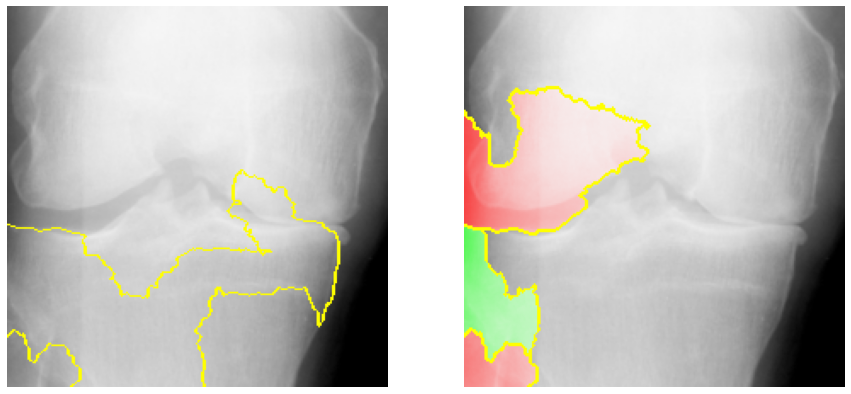

In [ ]:
# plot image with LIME mask

from skimage.segmentation import mark_boundaries
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=3, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

#### GradCam.py

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx=None, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

#### GradCam Impl

In [ ]:
img_path = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test/4/9598976_2.png'

In [ ]:
# load test image
image_test = cv2.imread(img_path)
image_test = image_test.reshape((1, 224, 224, 3))

In [ ]:
# pred_ = loaded_model.predict(image_test.astype('uint8'))
# print(np.argmax(pred_[0]))

In [ ]:
# i = np.argmax(pred[0])

In [ ]:
# get layer names
# for idx in range(len(model.layers)):
#   print(model.get_layer(index = idx).name)

In [ ]:
image = cv2.imread(img_path)
image = cv2.resize(image, (224, 224))

image_re = image.reshape((1, 224, 224, 3))

In [ ]:
print(image.shape, image_re.shape)

(224, 224, 3) (1, 224, 224, 3)


In [ ]:
model_temp = tf.keras.models.load_model('/content/drive/MyDrive/DSP-H3-Quin/model_stuff/model_01.h5')

In [ ]:
# compute heatmap
icam = GradCAM(model, layerName='conv5_block32_concat') 
heatmap = icam.compute_heatmap(image_test)
heatmap = cv2.resize(heatmap, (224, 224))

In [ ]:
print(heatmap.shape, image.shape, image_re.shape)

(224, 224) (224, 224, 3) (1, 224, 224, 3)


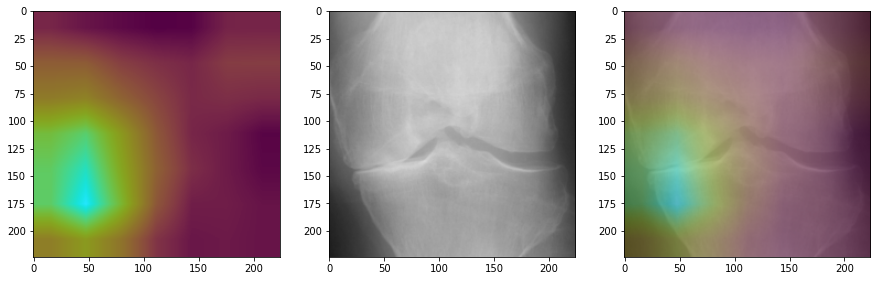

In [ ]:
# overlay heatmap onto test image
(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)


In [ ]:
heatmap2 = icam.compute_heatmap(image_test)
heatmap2 = cv2.resize(heatmap, (224, 224))

In [ ]:
image2 = cv2.imread(img_path)
image2 = cv2.resize(image, (224, 224))

In [ ]:
print(heatmap2.shape)
print(image2.shape)

(224, 224, 3)
(224, 224, 3)


In [ ]:
from google.colab.patches import cv2_imshow

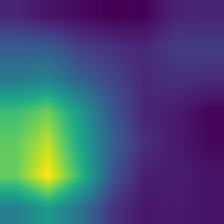

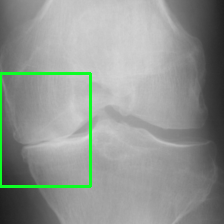

In [ ]:
gray = cv2.cvtColor(heatmap2, cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = cv2.threshold(gray, 100, 100, 0)[1]

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    w *= 0.9
    h *= 0.75

    w, h = int(w), int(h)

    rect = cv2.rectangle(image2, (x, y), (x + w, y + h), (36,255,12), 2)

cv2_imshow(heatmap2)
cv2_imshow(image2)

In [ ]:
heatmap2.shape

(224, 224, 3)

#### Score-CAM

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import gc

tf.compat.v1.disable_eager_execution()

def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

def GradCam(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    
    """GradCAM method for visualizing input saliency."""
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img_array])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    weights = np.mean(grads_val, axis=(0, 1))

    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0  

    return cam

def GradCamPlusPlus(model, img_array, layer_name):
    cls = np.argmax(model.predict(img_array))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = tf.gradients(y_c, conv_output)[0]
    # grads = normalize(grads)

    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads*grads

    gradient_function = K.function([model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img_array])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)
    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)

    cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)
    cam = np.maximum(cam, 0)  # Passing through ReLU
    cam /= np.max(cam) # scale 0 to 1.0  

    return cam

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model.predict(img_array))
    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsampled to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

import tensorflow.keras

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras.applications.vgg16 import preprocess_input

def build_guided_model(build_model_function):
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.compat.v1.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model_function()
    return new_model

def GuidedBackPropagation(model, img_array, layer_name):
    model_input = model.input
    layer_output = model.get_layer(layer_name).output
    max_output = K.max(layer_output, axis=3)
    grads = tf.gradients(max_output, model_input)[0]
    get_output = K.function([model_input], [grads])
    saliency = get_output([img_array])
    saliency = np.clip(saliency[0][0], 0.0, 1.0)  # scale 0 to 1.0  
    return saliency

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asa

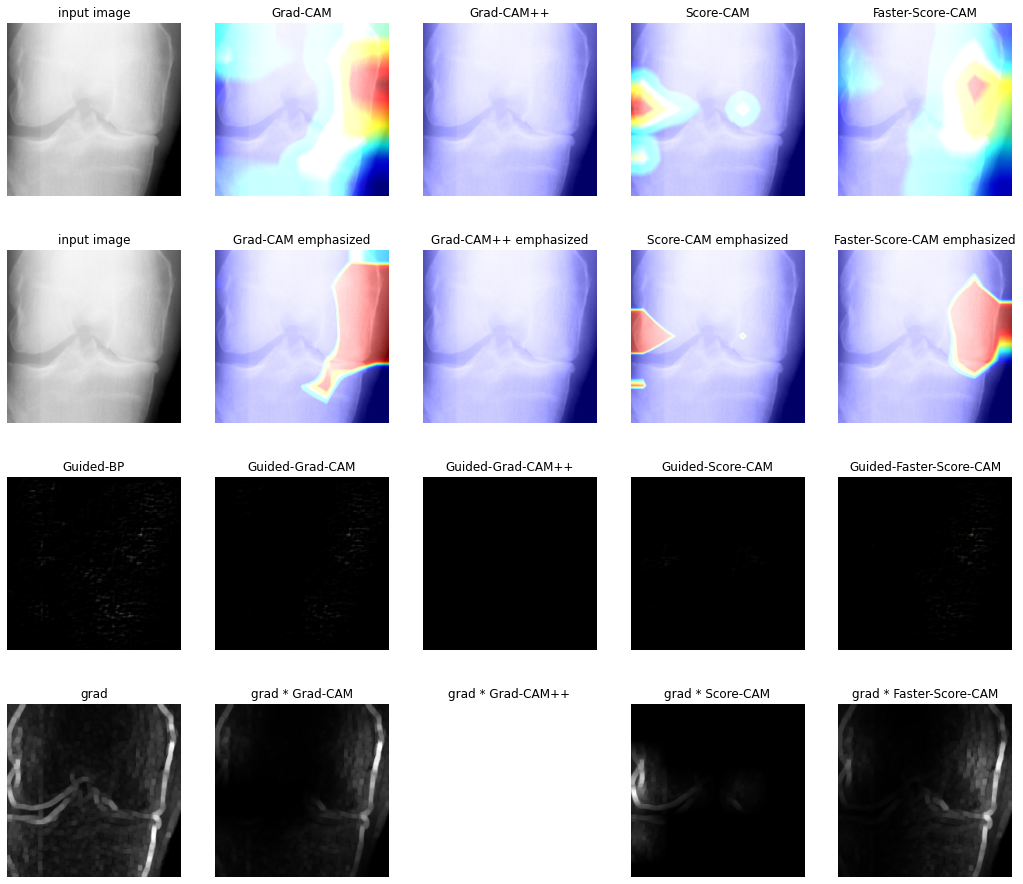

In [ ]:
img_path = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test/4/9012867R.png'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

layer_name = "conv5_block32_concat"

grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

saliency = GuidedBackPropagation(model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

faster_score_cam_resized = cv2.resize(faster_score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  #Get image gradient
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  #Fattening process
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized
grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 16))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
ax[0,3].imshow(score_cam_superimposed)
ax[0,3].set_title("Score-CAM")
ax[0,4].imshow(faster_score_cam_superimposed)
ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
ax[1,3].imshow(score_cam_emphasized)
ax[1,3].set_title("Score-CAM emphasized")
ax[1,4].imshow(faster_score_cam_emphasized)
ax[1,4].set_title("Faster-Score-CAM emphasized")
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
ax[2,3].imshow(guided_score_cam)
ax[2,3].set_title("Guided-Score-CAM")
ax[2,4].imshow(guided_faster_score_cam)
ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
ax[3,3].imshow(grad_times_score_cam, 'gray')
ax[3,3].set_title("grad * Score-CAM")
ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
ax[3,4].set_title("grad * Faster-Score-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()

### PyTorch Pre-trained Model (ignore this part for now)

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
ROOT_train = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/train'
ROOT_val = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/val'
ROOT_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/test'
ROOT_auto_test = '/content/drive/MyDrive/DSP-H3-Quin/data_set/kneeKL224/auto_test'

In [ ]:
model = torch.load('/content/drive/MyDrive/DSP-H3-Quin/model_stuff/densenet169/densenet-169-SGD-0/6-0.665-0.668-0.522.pth')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torchvision.models.densenet.DenseNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or 

In [ ]:
# model.eval()

In [ ]:
test_dataset = ImageFolder(ROOT_auto_test, transform=ToTensor())

In [ ]:
classes = test_dataset.classes

Label:  0 (0)


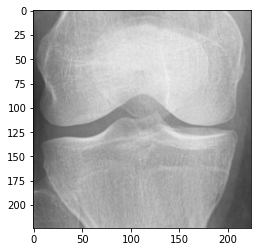

In [ ]:
def show_example(img, label):
    print('Label: ', test_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
show_example(*test_dataset[0])

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(224),                    #[2]
 transforms.CenterCrop(224),                #[3]
#  transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]
 )])


In [ ]:
img, label = test_dataset[0]

In [ ]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

In [ ]:
model2 = torch.load('/content/drive/MyDrive/DSP-H3-Quin/model_stuff/vgg16/vgg-16-SGD-0/5-0.64-0.671-0.585.pth')

In [ ]:
model2.eval()

In [ ]:
output = model2(batch_t)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

AttributeError: ignored

In [ ]:
out = model2(batch_t)

AttributeError: ignored

In [ ]:
classes = [test_dataset.classes] # change to labels probably
_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 10
print(labels[index[0]], percentage[index[0]].item())

NameError: ignored

In [ ]:
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]